In [86]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans, DBSCAN
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score

In [87]:
df=pd.read_excel('/content/Online Retail.xlsx')
df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom


In [88]:
# Handle missing values
df = df.dropna(subset=["CustomerID"])
df = df[df['Quantity'] > 0]
df = df[df['UnitPrice'] > 0]
df["TotalPrice"] = df["Quantity"] * df["UnitPrice"]

In [89]:
customer_df = df.groupby('CustomerID').agg({
    'TotalPrice': 'sum',
    'Quantity': 'sum',
    'InvoiceNo': 'nunique'
}).reset_index()
customer_df.rename(columns={'InvoiceNo': 'TransactionCount'}, inplace=True)

In [90]:
scaler = StandardScaler()
scaled_data = scaler.fit_transform(customer_df[['TotalPrice', 'TransactionCount','Quantity']])

In [91]:
customer_df.head()

,CustomerID,TotalPrice,Quantity,TransactionCount
0,12346.0,77183.60,74215,1
1,12347.0,4310.00,2458,7
2,12348.0,1797.24,2341,4
3,12349.0,1757.55,631,1
4,12350.0,334.40,197,1


In [92]:
# Finding optimal clusters using Elbow Method
wcss = []
for i in range(1, 11):
    kmeans = KMeans(n_clusters=i, random_state=42, n_init=10)
    kmeans.fit(scaled_data)
    wcss.append(kmeans.inertia_)

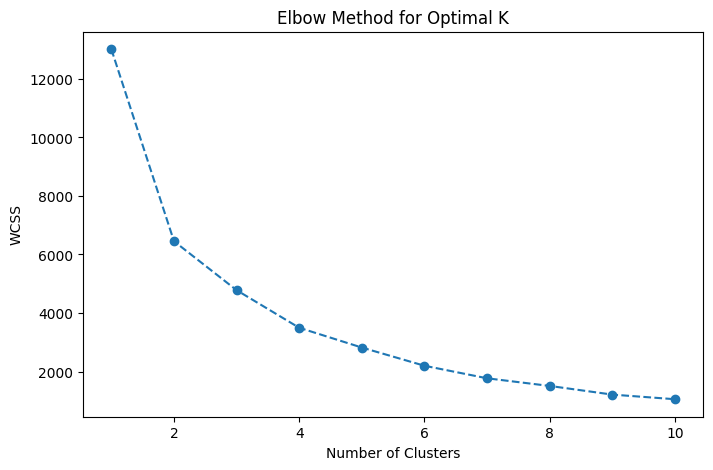

In [93]:
plt.figure(figsize=(8,5))
plt.plot(range(1, 11), wcss, marker='o', linestyle='--')
plt.xlabel('Number of Clusters')
plt.ylabel('WCSS')
plt.title('Elbow Method for Optimal K')
plt.show()

In [95]:
# Apply K-Means Clustering
optimal_clusters = 4
kmeans = KMeans(n_clusters=optimal_clusters, random_state=42, n_init=10)
customer_df['Cluster'] = kmeans.fit_predict(scaled_data)

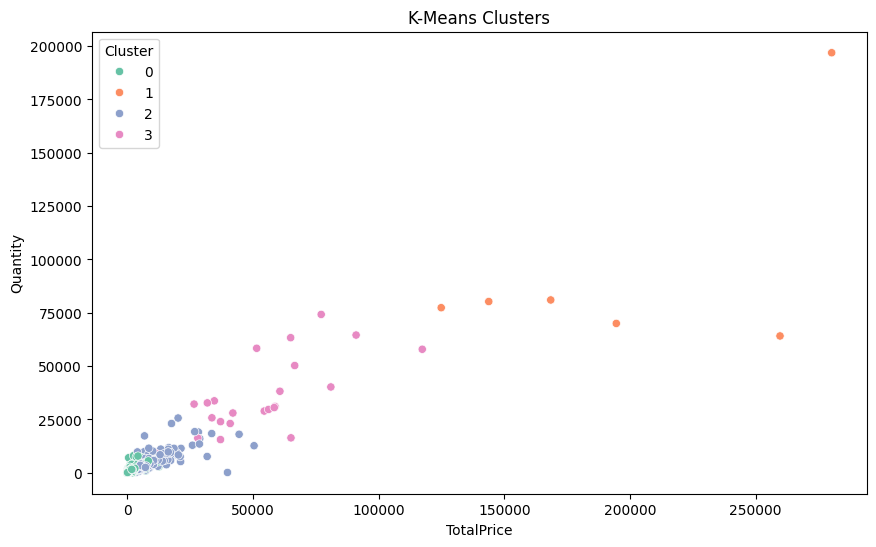

In [107]:
# Visualizing the Clusters
import seaborn as sns
plt.figure(figsize=(10, 6))
sns.scatterplot(x='TotalPrice', y='Quantity', hue='Cluster',
                data=customer_df, palette='Set2')
plt.title('K-Means Clusters')
plt.show()

In [108]:
cluster_report = customer_df.groupby('Cluster').agg({'TotalPrice': ['count', 'mean', 'sum'],
                                                     'TransactionCount': ['mean', 'sum']})
print("Cluster Report:\n", cluster_report)

Cluster Report:
         TotalPrice                             TransactionCount       
             count           mean          sum             mean    sum
Cluster                                                               
0             3968     986.517718  3914502.304         2.817036  11178
1                6  195271.033333  1171626.200        67.166667    403
2              340    7604.762588  2585619.280        16.394118   5574
3               24   51652.505000  1239660.120        57.375000   1377


Number of clusters (excluding noise): 2
Noise points (Cluster -1): 75


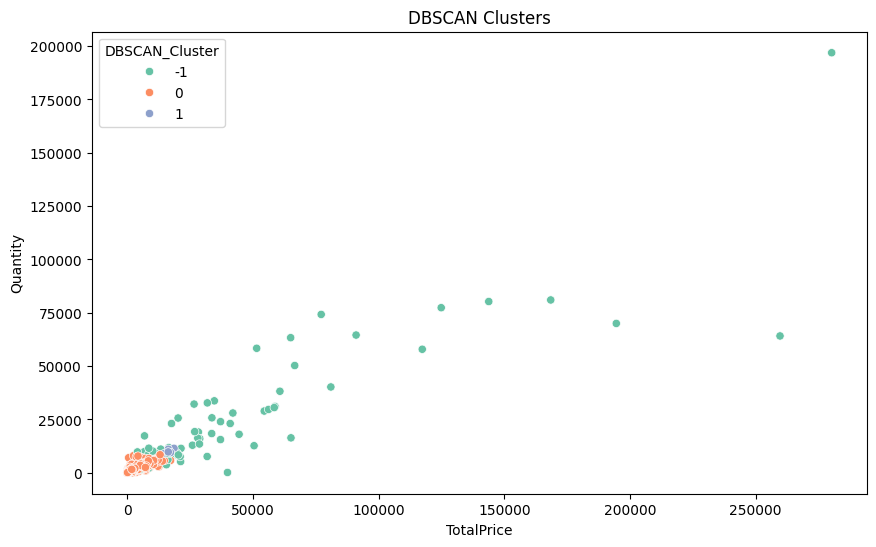

In [135]:
# Apply DBSCAN
dbscan = DBSCAN(eps=0.5, min_samples=5)
customer_df['DBSCAN_Cluster'] = dbscan.fit_predict(scaled_data)

# Analyze DBSCAN results
print("Number of clusters (excluding noise):", len(set(customer_df['DBSCAN_Cluster'])) - 1)
print("Noise points (Cluster -1):", (customer_df['DBSCAN_Cluster'] == -1).sum())

# Visualize DBSCAN clusters
plt.figure(figsize=(10, 6))
sns.scatterplot(x='TotalPrice', y='Quantity', hue='DBSCAN_Cluster',
                data=customer_df, palette='Set2')
plt.title('DBSCAN Clusters')
plt.show()

K-Means Silhouette Score: 0.768
DBSCAN Silhouette Score: 0.828


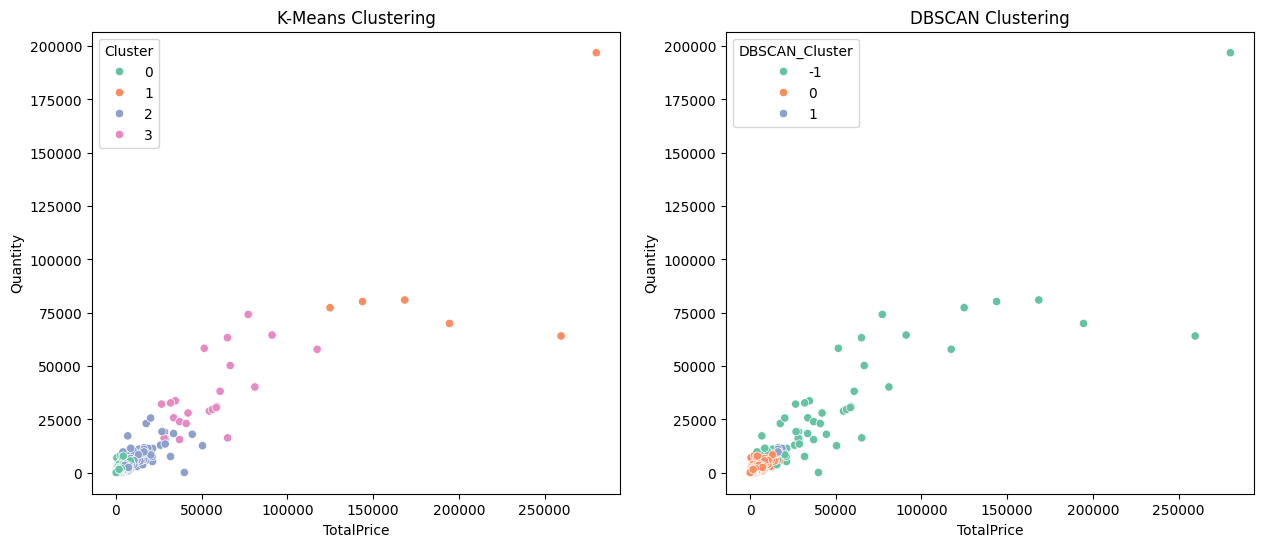

In [138]:
kmeans_silhouette = silhouette_score(scaled_data, customer_df['Cluster'])
print(f"K-Means Silhouette Score: {kmeans_silhouette:.3f}")
dbscan_silhouette = silhouette_score(scaled_data, customer_df['DBSCAN_Cluster'])
print(f"DBSCAN Silhouette Score: {dbscan_silhouette:.3f}")

# Visualize side-by-side
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))
sns.scatterplot(x='TotalPrice', y='Quantity', hue='Cluster', data=customer_df,
                palette='Set2', ax=ax1)
ax1.set_title('K-Means Clustering')
sns.scatterplot(x='TotalPrice', y='Quantity', hue='DBSCAN_Cluster', data=customer_df,
                palette='Set2', ax=ax2)
ax2.set_title('DBSCAN Clustering')
plt.show()

# Comparison of K-Means and DBSCAN
Clustering Approach: K-Means partitions data into a fixed number of

*  Clustering Approach: K-Means partitions data into a fixed number of clusters, while DBSCAN determines clusters dynamically based on data density
*   Data Distribution: K-Means works best with evenly spread data, while DBSCAN handles unevenly distributed data more effectively.
*  Sensitivity to Parameters: K-Means requires predefining the number of clusters, while DBSCAN's results depend on eps and min_samples for density estimation.